In [1]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
#from tensorflow.keras.utils import to_categorical ## specific  one I wanna use
from tensorflow.keras import utils
#from tensorflow.keras.layers import Input, Dense, Dropout  # Specific ones I wanna use, can just import whole module
from tensorflow.keras import layers 
from tensorflow.keras.models import Model
import h5py
#import tables
import matplotlib.pyplot as plt
#import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight


from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

from tensorflow.keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
import tensorflow as tf
gpu_available = tf.test.is_gpu_available()
gpu_available

True

In [3]:
m=1
n=2
m+n



3

In [4]:
# Load the HDF5 file
with h5py.File('DF_event_based.h5', 'r') as hf:
    # Access the dataset by name and load it into a pandas dataframe
    df_total = pd.DataFrame(hf['dataset_name'][:])

with h5py.File('4_event_types_weights.h5', 'r') as f:
    df_weights = f['array'][:]

with h5py.File('predictions_16pad_128_50epoch_4Layers_SEED10.h5', 'r') as f:
    predicted_val = f['val_preds'][:]
    predicted_train = f['train_preds'][:]

with h5py.File('4_event_types_labels.h5', 'r') as f:
    df_labels = f['array'][:]

In [5]:
# df's now have no titles, but doesnt matter for the model obvs.
df_total = df_total.rename(columns={df_total.columns[0]: 'dataset'})
df_Xvars = df_total.drop(['dataset'], axis = 1, inplace = False)   #Need to remove dataset (prediction) column

In [6]:
x = df_Xvars.values
y = df_labels

X_train, X_valid, y_train, y_valid = train_test_split(x, y, train_size=0.8, test_size=0.2,
                                                      random_state=10)

input_shape = [X_train.shape[1]]
print('There are', input_shape, 'variables in this model')
print('The dataset has', len(y), 'processes')
print(input_shape)

There are [10] variables in this model
The dataset has 881096 processes
[10]


In [7]:
predicted_train

array([[0.61670357],
       [0.4636152 ],
       [0.50274837],
       ...,
       [0.20900938],
       [0.7831093 ],
       [0.48962942]], dtype=float32)

In [8]:
X_train = np.hstack((X_train, predicted_train))
X_valid = np.hstack((X_valid, predicted_val))
print(X_train.shape)
print(X_valid.shape)
print(X_train[:,-1])
print(predicted_train)

input_shape = [X_train.shape[1]] 

(704876, 11)
(176220, 11)
[0.61670357 0.46361521 0.50274837 ... 0.20900938 0.78310931 0.48962942]
[[0.61670357]
 [0.4636152 ]
 [0.50274837]
 ...
 [0.20900938]
 [0.7831093 ]
 [0.48962942]]


In [9]:
#Define the Model

model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape), 
    layers.Dense(units=512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate = 0.2), 
    layers.Dense(units=512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate = 0.2),
    layers.Dense(units=1, activation='sigmoid'),
])


from tensorflow.keras.optimizers import Adam, SGD, Adagrad, RMSprop

lr = 0.0001 # specify learning rate
optimizer = Adam(learning_rate=lr)
#optimizer = SGD(learning_rate=lr)
#optimizer = Adagrad(learning_rate=lr)
#optimizer = RMSprop(learning_rate=lr)


   # 'optimizer': ['adagrad', 'sgd', 'adam', 'rmsprop'],


model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)


model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 11)                44        
_________________________________________________________________
dense (Dense)                (None, 512)               6144      
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

In [10]:
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
print(class_weights)

[0.62673917 2.47255507]


Train on 704876 samples, validate on 176220 samples
Epoch 1/200
704876/704876 [==============================] - 25s 35us/sample - loss: 0.5827 - binary_accuracy: 0.7074 - val_loss: 0.5533 - val_binary_accuracy: 0.7313
Epoch 2/200
704876/704876 [==============================] - 21s 30us/sample - loss: 0.5553 - binary_accuracy: 0.7229 - val_loss: 0.5517 - val_binary_accuracy: 0.7281
Epoch 3/200
704876/704876 [==============================] - 16s 23us/sample - loss: 0.5473 - binary_accuracy: 0.7279 - val_loss: 0.5507 - val_binary_accuracy: 0.7217
Epoch 4/200
704876/704876 [==============================] - 11s 16us/sample - loss: 0.5427 - binary_accuracy: 0.7316 - val_loss: 0.5487 - val_binary_accuracy: 0.7217
Epoch 5/200
704876/704876 [==============================] - 15s 21us/sample - loss: 0.5406 - binary_accuracy: 0.7333 - val_loss: 0.5484 - val_binary_accuracy: 0.7347
Epoch 6/200
704876/704876 [==============================] - 19s 27us/sample - loss: 0.5394 - binary_accuracy: 0.

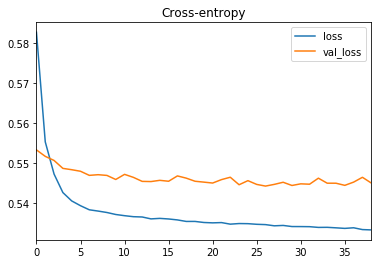

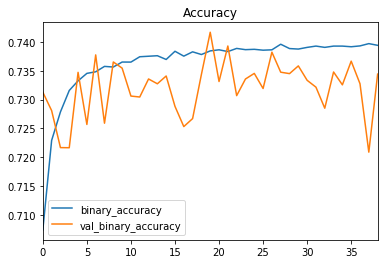

In [11]:
# Train the model, on the full data set

early_stopping = keras.callbacks.EarlyStopping(
    patience=15,
    min_delta=0.001,
    restore_best_weights=True,
)

#class_weight = {0: 1,
 #               1: len(df2)/len(df4)}
    
#ratio = 1/0.27
#class_weight = {0: 0.27 * ratio,
#                1: 0.73 * ratio}

class_weight = {0: class_weights[0], 
               1: class_weights[1]}        # Done by compute_class_weight('balanced', np.unique(y_train), y_train) in cell above


#class_weight = {0: 1, 
 #                1: 2.25} 


history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=200,
    callbacks=[early_stopping],
    #verbose = 0   #Hide output of epochs
    class_weight = class_weight
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")
history_df = pd.DataFrame(history.history)

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

#takes like 10 mins to run rn, only 3 layers

Best Validation Loss: 0.5443
Best Validation Accuracy: 0.7417


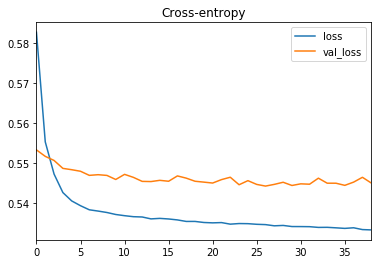

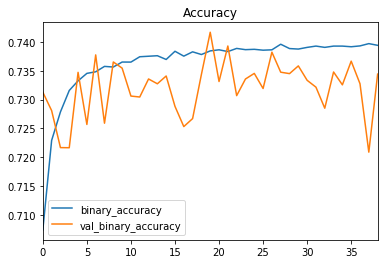

In [12]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")
history_df = pd.DataFrame(history.history)

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))


In [13]:
4

4

In [14]:
# evaluate the model on the training data, confusion matrix and discriminator curve


# val_loss, val_acc = model.evaluate(X_train, y_train)    

# print("Validation loss:", val_loss)
# print("Validation accuracy:", val_acc)

# y_pred = model.predict(X_train)
# y_pred_round = np.round(y_pred)
# #print(y_pred)

# # compute the confusion matrix
# cm = confusion_matrix(y_train, y_pred_round, normalize = 'true')   #, normalize = 'true')  #,'true' ‘pred’, ‘all’},)
# #disp = ConfusionMatrixDisplay(confusion_matrix=cm)  
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1']) # other env
# disp.plot()
# plt.show()

# print('Total signal processes;', cm[1,0]+cm[1,1])
# print('Total background processes;', cm[0,0]+cm[0,1])

# # Check if order of y_valid is the same order as y_pred
# # expect to be the ssame order if accuracy is same as validation accuracy above.

# # list of true outcomes
# y_train_list = list(y_train)

# # list of rounded predictions 
# y_pred_round_list = list(y_pred_round)

# data_test = {'True_Val': y_train_list, 'Predicted': list(y_pred), 'Round Prediction': y_pred_round_list}
# df_test = pd.DataFrame(data_test)

# # Easiest to reorder df, so all 0 (background) are first and then 1's (signal)

# #Verified, works
# df_test = df_test.sort_values(by='True_Val')
# df_test

# # Convert arrays to scalars
# df_test['Round Prediction'] = df_test['Round Prediction'].apply(lambda x: x[0])
        
# pred_one = df_test['Round Prediction'].value_counts()[1.0]
# ones_in_set = df_test['True_Val'].value_counts()[1]

# # Print the result
# print(pred_one)
# print('There is', ones_in_set, 'signal in the set')
# print('The model predicted',pred_one-ones_in_set ,'more ones than in reality')


# pred_zeros = df_test['Round Prediction'].value_counts()[0.0]
# zeros_in_set = df_test['True_Val'].value_counts()[0]

# # Print the result
# print(pred_zeros)
# print('There is', zeros_in_set, 'background in the set')   #agrees w/ confusion matrix
# print('The model predicted', pred_zeros-zeros_in_set,'more ones than in reality')


# #Split df into signal and bg

# df_bg = df_test[df_test['True_Val'] == 0]
# df_signal = df_test[df_test['True_Val'] == 1]

# # Make discriminator curves, Histogram

# # manipluate data so can be used for Histograms
# lst_bg_predicted = []
# for i in df_bg['Predicted']:
#     lst_bg_predicted.append(i)

# lst_of_values_bg_pred_train = [arr.item() for arr in lst_bg_predicted]

# lst_signal_predicted = []
# for i in df_signal['Predicted']:
#     lst_signal_predicted.append(i)

# lst_of_values_signal_pred_train = [arr.item() for arr in lst_signal_predicted]

# binwidth = 0.01
# bins=np.arange(0, 1 + binwidth, binwidth)
    

# #Unweighted, normalised
# plt.hist(x= lst_of_values_bg_pred_train, bins=bins, density = True, histtype = 'step', label = 'Background')
# plt.hist(x= lst_of_values_signal_pred_train, bins=bins, density = True, histtype = 'step', label = 'Signal')
# plt.title('Discriminator Curve')
# plt.xlabel('Classifier Prediction')
# plt.ylabel('Frequency')
# plt.legend()
# plt.show()

# #Weighted to xs_weights x 300000, need to be toproportion of full dataset too
# #normalised

# plt.hist(x= lst_of_values_bg_pred_train, bins=bins,  weights = df2.xs_weight[:len(lst_of_values_bg_pred_train)]*3e5,
#          histtype = 'step', label = 'Background')
# plt.hist(x= lst_of_values_signal_pred_train, bins=bins, weights = df4.xs_weight[:len(lst_of_values_signal_pred_train)]*3e5,
#          histtype = 'step', label = 'Signal')
# plt.title('Discriminator Curve')
# plt.xlabel('Classifier Prediction')
# plt.ylabel('Frequency')
# plt.xlim(0.9,1)    #zoom in on 0.9 to 1 region
# plt.ylim(0,200)    # need to zoom in
# plt.legend()
# plt.show()


# #start dropping bins for signifucance part, calc Z and plot, should get curve that peaks

True


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation loss: 0.5266438004692097
Validation accuracy: 0.74192196
704876/1 - 20s


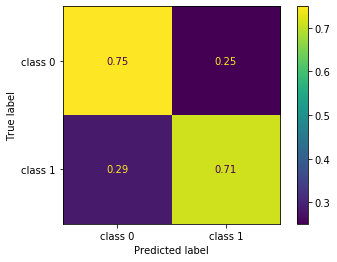

Total signal processes; 1.0
Total background processes; 1.0
242697
There is 142540 signal in the set
The model predicted 100157 more ones than in reality
462179
There is 562336 background in the set
The model predicted -100157 more ones than in reality


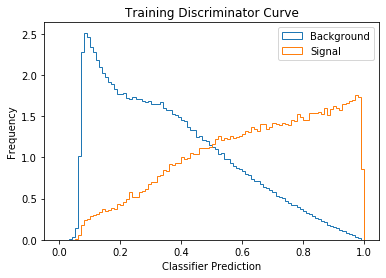

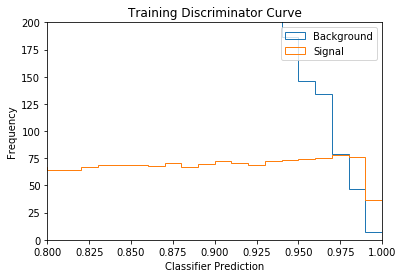

num_bg_events_training =  217205.81255412102
num_signal_events_training =  4411.063964322209


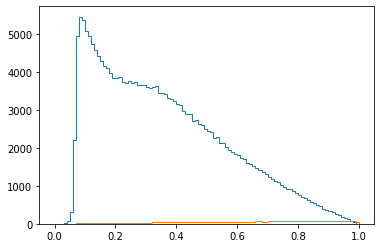

In [15]:
# evaluate the model on the training data, confusion matrix and discriminator curve

gpu_available = tf.test.is_gpu_available()
print(gpu_available)   # check still on the gpu

val_loss, val_acc = model.evaluate(X_train, y_train)    

print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

y_pred = model.predict(X_train, verbose = 2)
y_pred_round = np.round(y_pred)
#print(y_pred)

# compute the confusion matrix

cm = confusion_matrix(y_train, y_pred_round, normalize = 'true')   #, normalize = 'true')  #,'true' ‘pred’, ‘all’},)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1']) # other env

disp.plot()
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

# Check if order of y_valid is the same order as y_pred
# expect to be the ssame order if accuracy is same as validation accuracy above.

# list of true outcomes
y_train_list = list(y_train)

# list of rounded predictions 
y_pred_round_list = list(y_pred_round)

data_test = {'True_Val': y_train_list, 'Predicted': list(y_pred), 'Round Prediction': y_pred_round_list}
df_test = pd.DataFrame(data_test)

# Easiest to reorder df, so all 0 (background) are first and then 1's (signal)

#Verified, works
df_test = df_test.sort_values(by='True_Val')
df_test

# Convert arrays to scalars
df_test['Round Prediction'] = df_test['Round Prediction'].apply(lambda x: x[0])
        
pred_one = df_test['Round Prediction'].value_counts()[1.0]
ones_in_set = df_test['True_Val'].value_counts()[1]

# Print the result
print(pred_one)
print('There is', ones_in_set, 'signal in the set')
print('The model predicted',pred_one-ones_in_set ,'more ones than in reality')


pred_zeros = df_test['Round Prediction'].value_counts()[0.0]
zeros_in_set = df_test['True_Val'].value_counts()[0]

# Print the result
print(pred_zeros)
print('There is', zeros_in_set, 'background in the set')   #agrees w/ confusion matrix
print('The model predicted', pred_zeros-zeros_in_set,'more ones than in reality')


#Split df into signal and bg

df_bg = df_test[df_test['True_Val'] == 0]
df_signal = df_test[df_test['True_Val'] == 1]

# Make discriminator curves, Histogram

# manipluate data so can be used for Histograms
lst_bg_predicted = []
for i in df_bg['Predicted']:
    lst_bg_predicted.append(i)

lst_of_values_bg_pred_train = [arr.item() for arr in lst_bg_predicted]

lst_signal_predicted = []
for i in df_signal['Predicted']:
    lst_signal_predicted.append(i)

lst_of_values_signal_pred_train = [arr.item() for arr in lst_signal_predicted]

binwidth = 0.01
bins=np.arange(0, 1 + binwidth, binwidth)
    

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred_train, bins=bins, density = True, histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, density = True, histtype = 'step', label = 'Signal')
plt.title('Training Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#Weighted to xs_weights x 300000, need to be toproportion of full dataset too
#normalised

plt.hist(x= lst_of_values_bg_pred_train, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred_train),1]*3e5*1/0.8,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred_train),3]*3e5*1/0.8,
         histtype = 'step', label = 'Signal')
plt.title('Training Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.xlim(0.8,1)    #zoom in on 0.9 to 1 region
plt.ylim(0,200)    # need to zoom in
plt.legend()
plt.show()


#Calculate number of events

n_bg, bins_bg, patches_bg = plt.hist(x= lst_of_values_bg_pred_train, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred_train),1]*3e5*1/0.8,
         histtype = 'step', label = 'Background')
n_signal, bins_signal, patches_signal = plt.hist(x= lst_of_values_signal_pred_train, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred_train),3]*3e5*1/0.8,
         histtype = 'step', label = 'Signal')

# calculate the number of events
num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print('num_bg_events_training = ', num_bg_events)
print('num_signal_events_training = ', num_signal_events)

#start dropping bins for signifucance part, calc Z and plot, should get curve that peaks

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation loss: 0.5367753145088877
Validation accuracy: 0.733566


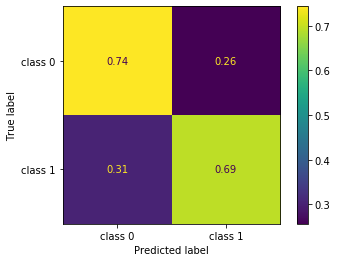

Total signal processes; 1.0
Total background processes; 1.0


In [16]:
# evaluate the model on the validation data

val_loss, val_acc = model.evaluate(X_valid, y_valid)   
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

y_pred = model.predict(X_valid)
y_pred_round = np.round(y_pred)

# compute the confusion matrix
cm = confusion_matrix(y_valid, y_pred_round, normalize = 'true')    #,'true' ‘pred’, ‘all’},)#
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1']) # other env
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)   
disp.plot()
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

In [17]:
# #using a permutation method to see what features are important

# # Get the number of features
# n_features = X_valid.shape[1]

# # Initialize an array to store feature importances
# importances = np.zeros(n_features)

# # Calculate the feature importances using the permutation feature importance method
# # Drops each variable one at a time 
# for i in range(n_features):
#     print(i)    #counter to check is working, should go to 40
#     feature_name = X_valid.columns[i]
#     X_permuted = X_valid.copy().values
#     X_permuted[:, i] = np.random.permutation(X_permuted[:, i])
#     y_permuted = model.predict(X_permuted)
#     importances[i] = np.abs(y_permuted - y_pred).mean()
#     #importances[i] = (y_permuted - y_pred).mean()    #try without a abs, see if positively or negatively affected by removal?
#     print(f"Permuted feature {feature_name}")

# # Normalize the feature importances
# importances /= importances.sum()   # importances sum to 1, so can be taken as a literal how important a variable
# # is for the model

# print(importances)  # using abs

# print()#

# print(np.sort(importances))

# # np.random.permutation randomly permutes (rearranges in a random order) the elements.
# # In this case, it is used to shuffle the values in a single column of the X_permuted array.
# # Guess then this variable isnt useful in the prediction

In [18]:
# importances_dict = dict(zip(importances, X_valid.columns))
# # key:value

# #print(combined_dict)

# # get values for keys less than 0.01
# values = []
# for key, value in importances_dict.items():
#     if key < 0.01:
#         values.append(value)

# # print the values
# print(values)


In [19]:
# get indices of numbers less than 0.01
# for i in range(len(importances)):
#     if importances[i] < 0.05:
#         print(X_valid.columns[i])

In [20]:
# Check if order of y_valid is the same order as y_pred
# expect to be the ssame order if accuracy is same as validation accuracy above.

# list of true outcomes
y_valid_list = list(y_valid)

# list of rounded predictions 
y_pred_round_list = list(y_pred_round)

# list of whether these are same    
z=[]
for i in range(len(y_valid_list)):
    if y_valid_list[i]==y_pred_round_list[i]:
        z.append(1)
    else:
        z.append(0)
        
print(sum(z)/len(z))

# Set a tolerance
tol = 0.0001
print(val_acc - tol < sum(z)/len(z) < val_acc + tol)

# If true, suggests are in same order 

0.7335659970491432
True


In [21]:
print(min(y_pred))
max(y_pred)

[0.03117564]


array([0.9994116], dtype=float32)

In [22]:
data = {'True_Val': y_valid_list, 'Predicted': list(y_pred), 'Round Prediction': y_pred_round_list}
df = pd.DataFrame(data)

# Easiest to reorder df, so all 0 (background) are first and then 1's (signal)

#Verified, works
df = df.sort_values(by='True_Val')
df

# Convert arrays to scalars
df['Round Prediction'] = df['Round Prediction'].apply(lambda x: x[0])

In [23]:
# Check that they maintained order in the df:

lst=[]
for i in range(len(df)):
    if df['True_Val'][i] == df['Round Prediction'][i]:
        lst.append(1)
    else:
        (lst.append(0))
print(sum(lst)/len(lst))

# Set a tolerance
tol = 0.0001
print(val_acc - tol < sum(lst)/len(lst) < val_acc + tol)

# If true, suggests are in same order 

0.7335659970491432
True


In [24]:
pred_one = df['Round Prediction'].value_counts()[1.0]
ones_in_set = df['True_Val'].value_counts()[1]

# Print the result
print(pred_one)
print('There is', ones_in_set, 'signal in the set')
print('The model predicted',pred_one-ones_in_set ,'more ones than in reality')


pred_zeros = df['Round Prediction'].value_counts()[0.0]
zeros_in_set = df['True_Val'].value_counts()[0]

# Print the result
print(pred_zeros)
print('There is', zeros_in_set, 'background in the set')   #agrees w/ confusion matrix
print('The model predicted', pred_zeros-zeros_in_set,'more ones than in reality')


60715
There is 35318 signal in the set
The model predicted 25397 more ones than in reality
115505
There is 140902 background in the set
The model predicted -25397 more ones than in reality


now first half of df is background, other half is signal

PROBLEM, TEST AND VALID WAS SPLIT RANDOMLY, SO NOT ACTUALLY SAME AMOUNT OF 0's AND 1's

Not a problem, but need to check if should be like this

 A couple of options, I could:

Deal with it, and let there be uneven amounts of 1's and 0's

OR

Go back to test_train_split, and apply individually to signal and background and then sum them?

This would guarantee 50/50


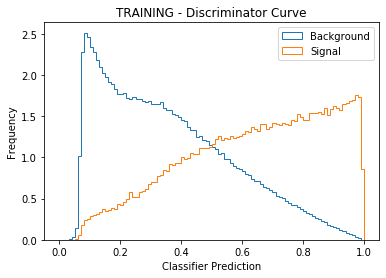

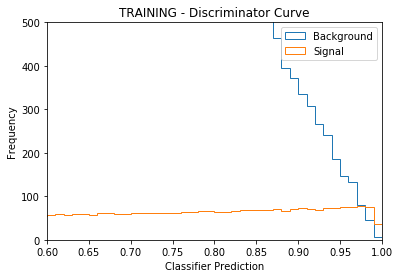

In [25]:
# Training Discriminator curves

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred_train, bins=bins, density = True, histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, density = True, histtype = 'step', label = 'Signal')
plt.title('TRAINING - Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#Weighted to xs_weights x 300000, need to be toproportion of full dataset too
#normalised


plt.hist(x= lst_of_values_bg_pred_train, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred_train),1]*3e5*1/0.8,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred_train),3]*3e5*1/0.8,
         histtype = 'step', label = 'Signal')
plt.title('TRAINING - Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.xlim(0.6,1)    #zoom in on 0.9 to 1 region
plt.ylim(0,500)    # need to zoom in
plt.legend()
plt.show()


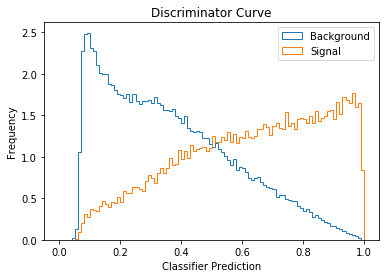

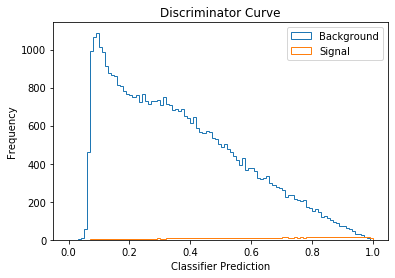

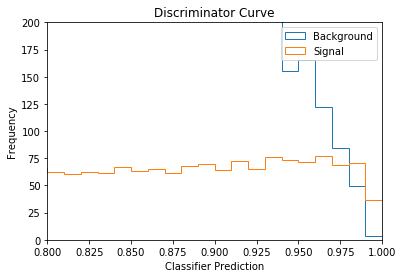

In [26]:
#Split df into signal and bg

df_bg = df[df['True_Val'] == 0]
df_signal = df[df['True_Val'] == 1]

# Make Validation discriminator curves, Histogram

# manipluate data so can be used for Histograms
lst_bg_predicted = []
for i in df_bg['Predicted']:
    lst_bg_predicted.append(i)

lst_of_values_bg_pred = [arr.item() for arr in lst_bg_predicted]

lst_signal_predicted = []
for i in df_signal['Predicted']:
    lst_signal_predicted.append(i)

lst_of_values_signal_pred = [arr.item() for arr in lst_signal_predicted]

binwidth = 0.01
bins=np.arange(0, 1 + binwidth, binwidth)

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred, bins=bins, density = True, histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred, bins=bins, density = True, histtype = 'step', label = 'Signal')
plt.title('Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#Weighted to xs_weights x 300000, need to be toproportion of full dataset too
#normalised
plt.hist(x= lst_of_values_bg_pred, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred),1]*3e5,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred),3]*3e5,
         histtype = 'step', label = 'Signal')
plt.title('Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
#plt.xlim(0.9,1)    #zoom in on 0.9 to 1 region
#plt.ylim(0,200)    # need to zoom in
plt.legend()
plt.show()
    
plt.hist(x= lst_of_values_bg_pred, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred),1]*3e5*1/0.2,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred),3]*3e5*1/0.2,
         histtype = 'step', label = 'Signal')
plt.title('Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.xlim(0.8,1)    #zoom in on 0.9 to 1 region
plt.ylim(0,200)    # need to zoom in
plt.legend()
plt.show()


#start dropping bins for signifucance part, calc Z and plot, should get curve that peaks

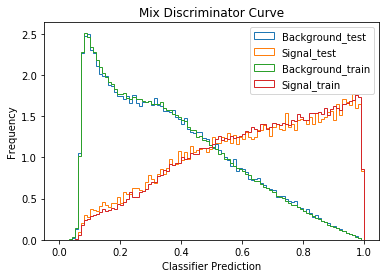

In [27]:
# Test and Training overlayed

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred, bins=bins, density = True, histtype = 'step', label = 'Background_test')
plt.hist(x= lst_of_values_signal_pred, bins=bins, density = True, histtype = 'step', label = 'Signal_test')
plt.title('Test - Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()


#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred_train, bins=bins, density = True, histtype = 'step', label = 'Background_train')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, density = True, histtype = 'step', label = 'Signal_train')
plt.title('Mix Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

num_bg_events_validation =  217678.7029671669
num_signal_events_validation =  4367.311522722244


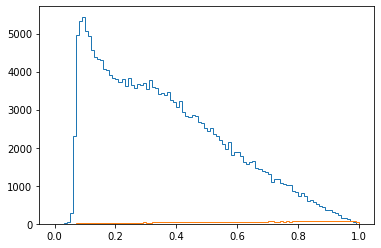

In [28]:
#Calculate number of events

n_bg, bins_bg, patches_bg = plt.hist(x= lst_of_values_bg_pred, bins=bins, weights = df_weights[:len(lst_of_values_bg_pred),1]*3e5*1/0.2,
         histtype = 'step', label = 'Background')
n_signal, bins_signal, patches_signal = plt.hist(x= lst_of_values_signal_pred, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred),3]*3e5*1/0.2,
         histtype = 'step', label = 'Signal')

# calculate the number of events
num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print('num_bg_events_validation = ', num_bg_events)
print('num_signal_events_validation = ', num_signal_events)

In [29]:
# #plot ROC curves

# y_true = df['True_Val']
# y_score = df['Predicted']

# # calculate the false positive rate and true positive rate
# fpr, tpr, thresholds = roc_curve(y_true, y_score)

# # calculate the area under the ROC curve
# roc_auc = auc(fpr, tpr)

# # plot the ROC curve
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()

# print(roc_auc)  #79%

# print(len(thresholds))



In [30]:
# data_roc = {'thresholds': thresholds, 'tpr': tpr, 'fpr': fpr, 'tpr/sqrt(fpr)':tpr/np.sqrt(fpr)}
# df_roc = pd.DataFrame(data_roc)
# #df_roc
# df_roc.head(20)
# plt.plot(df_roc['thresholds'][3:], df_roc['tpr/sqrt(fpr)'][3:])
# plt.show()
# max(df_roc['tpr/sqrt(fpr)'][3:])

In [31]:
# # Plot precision recall curve
# from sklearn.metrics import average_precision_score

# y_true = df['True_Val']
# y_score = df['Predicted']

# # calculate the precision-recall curve
# precision, recall, _ = precision_recall_curve(y_true, y_score)

# # plot the precision-recall curve
# plt.step(recall, precision, color='b', alpha=0.2, where='post')
# plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('Precision-Recall Curve')
# plt.show()

# AUC = average_precision_score(y_true, y_score)   #0.793, pretty similar to roc AUC
# print(AUC)

In [32]:
df['True_Val']
x = df['Predicted']
print(x)

88109      [0.21280408]
111032     [0.37933815]
111033     [0.08448091]
111034     [0.07630986]
111035    [0.118789166]
              ...      
27764       [0.9625344]
141597      [0.7277113]
27763       [0.9582325]
100490      [0.7810064]
0          [0.36558178]
Name: Predicted, Length: 176220, dtype: object


# Significance

$$ Z = \frac{s}{\sqrt(B+\sigma_s^{2})}  $$

s = number of signal

B = number of background

$\sigma_s$ = statistical uncertainty (~10% of B)

217678.7029671669
4367.311522722244


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


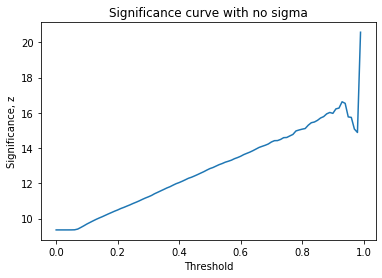

0.99
99
20.569777640914456

If cut at a threshold of 0.99 have
36.63427734375 singal events
3.171875 background events


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less


In [33]:
num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print(num_bg_events)
print(num_signal_events)

z = np.empty(len(bins_bg))
for i in range(len(bins_bg)):
    num_bg_events = np.sum(n_bg[i:])
    num_signal_events = np.sum(n_signal[i:])
    #print(num_signal_events)
    z_i = num_signal_events / np.sqrt(num_bg_events)
    z[i] = z_i
#print(z)


x = np.linspace(0,1,len(z))
plt.plot(bins_bg,z[:])
#plt.xlim([0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('Threshold')
plt.ylabel('Significance, z')
plt.title('Significance curve with no sigma')
plt.show()


mask = z < 1e10     #just so doesnt include infs
index_of_max = np.argmax(z[mask])
max_value = np.amax(z[mask])


#index_of_max = np.nanargmax(z[:])
#max_value = np.nanmax(z[:])     # 1 point before last, should probs generalise so that can deal w inf etc 
max_bin = bins_bg[index_of_max]
print(max_bin)
print(index_of_max)
print(max_value)

# significance = sigmna, 6.5 signma, 5 sigma

num_bg_threshold = np.sum(n_bg[index_of_max:])
num_signal_threshold = np.sum(n_signal[index_of_max:])

print()
print('If cut at a threshold of', index_of_max/100, 'have')
print(num_signal_threshold, 'singal events')
print(num_bg_threshold, 'background events')

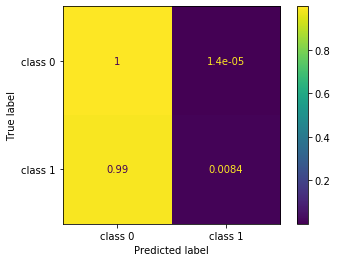

Total signal processes; 1.0
Total background processes; 1.0


In [34]:
# Confusion matricies with new threshold at max significance

# calculates prediction values
#y_pred = model.predict(X_valid) 

significance_threshold = max_bin
y_pred_threshold = np.where(y_pred >= significance_threshold, 1, 0)

# compute the confusion matrix
cm = confusion_matrix(y_valid, y_pred_threshold, normalize = 'true')    #,'true' ‘pred’, ‘all’},)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)   
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1']) # other env
disp.plot()
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

217678.7029671669
4367.311522722244


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


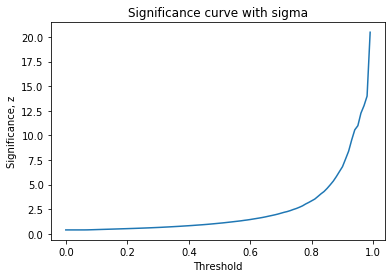

0.99
99
20.488703538454743

If cut at a threshold of 0.99 have
36.63427734375 singal events
3.171875 background events


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less


In [35]:
# significance with statistical uncertainty term

num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print(num_bg_events)
print(num_signal_events)

z = np.empty(len(bins_bg))
for i in range(len(bins_bg)):
    num_bg_events = np.sum(n_bg[i:])
    num_signal_events = np.sum(n_signal[i:])
    #print(num_signal_events)
    z_i = num_signal_events / np.sqrt(num_bg_events + (0.05*num_bg_events)**2)
    
    z[i] = z_i
#print(z)


x = np.linspace(0,1,len(z))
plt.plot(bins_bg,z[:])
#plt.xlim([0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('Threshold')
plt.ylabel('Significance, z')
plt.title('Significance curve with sigma')
plt.show()


mask = z < 1e10     #just so doesnt include infs
index_of_max = np.argmax(z[mask])
max_value = np.amax(z[mask])


#index_of_max = np.nanargmax(z[:])
#max_value = np.nanmax(z[:])     # 1 point before last, should probs generalise so that can deal w inf etc 
max_bin = bins_bg[index_of_max]
print(max_bin)
print(index_of_max)
print(max_value)

num_bg_threshold = np.sum(n_bg[index_of_max:])
num_signal_threshold = np.sum(n_signal[index_of_max:])
print()
print('If cut at a threshold of', index_of_max/100, 'have')
print(num_signal_threshold, 'singal events')
print(num_bg_threshold, 'background events')
# significance = sigmna, 6.5 signma, 5 sigma

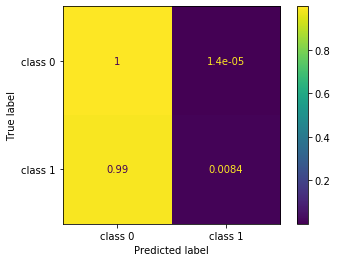

Total signal processes; 1.0
Total background processes; 1.0


In [36]:
# Confusion matricies with new threshold at max significance with statisitcal uncertainty

# calculates prediction values
#y_pred = model.predict(X_valid) 

significance_threshold = max_bin
y_pred_threshold = np.where(y_pred >= significance_threshold, 1, 0)

# compute the confusion matrix
cm = confusion_matrix(y_valid, y_pred_threshold, normalize = 'true')    #,'true' ‘pred’, ‘all’},)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)   
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1']) # other env
disp.plot()
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

217678.7029671669
4367.311522722244


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


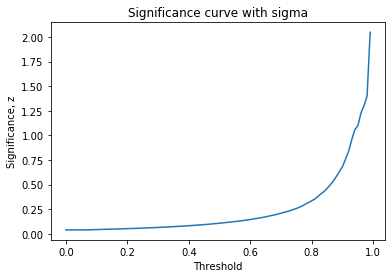

0.99
99
2.0488703538454742

If cut at a threshold of 0.99 have
36.63427734375 singal events
3.171875 background events


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less


In [37]:
# significance with statistical uncertainty term
# with only 10% 

num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print(num_bg_events)
print(num_signal_events)

z = np.empty(len(bins_bg))
for i in range(len(bins_bg)):
    num_bg_events = np.sum(n_bg[i:])
    num_signal_events = np.sum(n_signal[i:])
    #print(num_signal_events)
    z_i = (num_signal_events*0.1) / np.sqrt(num_bg_events + (0.05*num_bg_events)**2)
    
    z[i] = z_i
#print(z)


x = np.linspace(0,1,len(z))
plt.plot(bins_bg,z[:])
#plt.xlim([0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('Threshold')
plt.ylabel('Significance, z')
plt.title('Significance curve with sigma')
plt.show()


mask = z < 1e10     #just so doesnt include infs
index_of_max = np.argmax(z[mask])
max_value = np.amax(z[mask])


#index_of_max = np.nanargmax(z[:])
#max_value = np.nanmax(z[:])     # 1 point before last, should probs generalise so that can deal w inf etc 
max_bin = bins_bg[index_of_max]
print(max_bin)
print(index_of_max)
print(max_value)

num_bg_threshold = np.sum(n_bg[index_of_max:])
num_signal_threshold = np.sum(n_signal[index_of_max:])
print()
print('If cut at a threshold of', index_of_max/100, 'have')
print(num_signal_threshold, 'singal events')
print(num_bg_threshold, 'background events')
# significance = sigmna, 6.5 signma, 5 sigma

# Evaluate full datatset, should make significance more const

In [38]:
# Full Data
   
with h5py.File('full_predictions_16pad_128_50epoch_4Layers_SEED10.h5', 'r') as f:
               predicted_full = f['full_preds'][:]

In [39]:
len(predicted_full)


881096

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation loss: 0.5134509589654619
Validation accuracy: 0.7551969


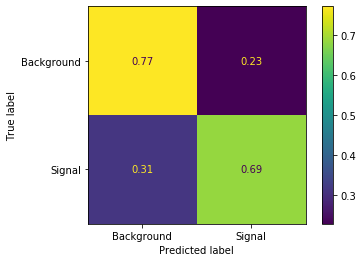

Total signal processes; 1.0
Total background processes; 1.0


In [42]:
# evaluate the model on the validation data

x = df_Xvars.values
X = np.hstack((x, predicted_full))

val_loss, val_acc = model.evaluate(X, y)   
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

y_pred_full = model.predict(X)
y_pred_full_round = np.round(y_pred_full)

# compute the confusion matrix
cm = confusion_matrix(y, y_pred_full_round, normalize = 'true')    #,'true' ‘pred’, ‘all’},)#
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Background', 'Signal']) # other env
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)   
disp.plot()
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

In [43]:
# Check if order of y_valid is the same order as y_pred
# expect to be the ssame order if accuracy is same as validation accuracy above.

# list of true outcomes
y_list = list(y)

# list of rounded predictions 
y_pred_full_round_list = list(y_pred_full_round)

# list of whether these are same    
z=[]
for i in range(len(y_list)):
    if y_list[i]==y_pred_full_round_list[i]:
        z.append(1)
    else:
        z.append(0)
        
print(sum(z)/len(z))

# Set a tolerance
tol = 0.0001
print(val_acc - tol < sum(z)/len(z) < val_acc + tol)

# If true, suggests are in same order 

0.7551969365426696
True


In [44]:
print(min(y_pred_full))
max(y_pred_full)

[0.02192491]


array([0.9995768], dtype=float32)

In [45]:
data = {'True_Val': y_list, 'Predicted': list(y_pred_full), 'Round Prediction': y_pred_full_round_list}
df = pd.DataFrame(data)

# Easiest to reorder df, so all 0 (background) are first and then 1's (signal)

#Verified, works
df = df.sort_values(by='True_Val')
df

# Convert arrays to scalars
df['Round Prediction'] = df['Round Prediction'].apply(lambda x: x[0])

In [46]:
# Check that they maintained order in the df:

lst=[]
for i in range(len(df)):
    if df['True_Val'][i] == df['Round Prediction'][i]:
        lst.append(1)
    else:
        (lst.append(0))
print(sum(lst)/len(lst))

# Set a tolerance
tol = 0.0001
print(val_acc - tol < sum(lst)/len(lst) < val_acc + tol)

# If true, suggests are in same order 

0.7551969365426696
True


In [47]:
pred_one = df['Round Prediction'].value_counts()[1.0]
ones_in_set = df['True_Val'].value_counts()[1]

# Print the result
print(pred_one)
print('There is', ones_in_set, 'signal in the set')
print('The model predicted',pred_one-ones_in_set ,'more ones than in reality')


pred_zeros = df['Round Prediction'].value_counts()[0.0]
zeros_in_set = df['True_Val'].value_counts()[0]

# Print the result
print(pred_zeros)
print('There is', zeros_in_set, 'background in the set')   #agrees w/ confusion matrix
print('The model predicted', pred_zeros-zeros_in_set,'more ones than in reality')


282025
There is 177858 signal in the set
The model predicted 104167 more ones than in reality
599071
There is 703238 background in the set
The model predicted -104167 more ones than in reality


now first half of df is background, other half is signal

PROBLEM, TEST AND VALID WAS SPLIT RANDOMLY, SO NOT ACTUALLY SAME AMOUNT OF 0's AND 1's

Not a problem, but need to check if should be like this

 A couple of options, I could:

Deal with it, and let there be uneven amounts of 1's and 0's

OR

Go back to test_train_split, and apply individually to signal and background and then sum them?

This would guarantee 50/50


In [48]:
SL = len(df_weights[:,1])


Di_mask = df_weights[:,2] > - 100
Di = len(df_weights[:,2][Di_mask])

Had_mask = df_weights[:,0] > - 100
Had = len(df_weights[:,0][Had_mask])

Higg_mask = df_weights[:,3] > - 100
Higg = len(df_weights[:,3][Higg_mask])

In [49]:
df_weights[:Higg,3]

# df_labels goes SL, Had, Di, Sig

df_weights[:,3][Higg_mask].shape

bg_weights = np.concatenate((df_weights[:,1], df_weights[:,0][Had_mask], df_weights[:,2][Di_mask]), axis=0)


#bg_weights

In [50]:
bg_weights.shape

(703238,)

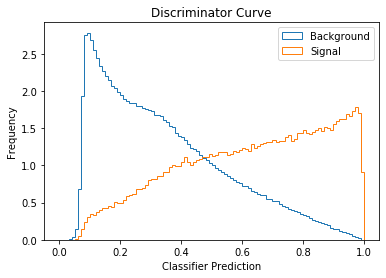

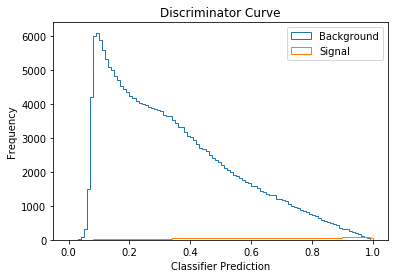

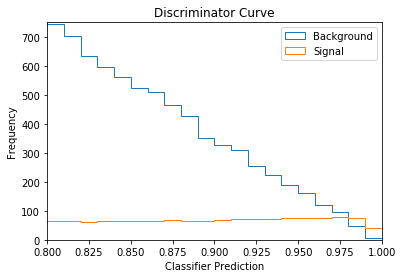

In [51]:
#Split df into signal and bg

df_bg = df[df['True_Val'] == 0]
df_signal = df[df['True_Val'] == 1]

# Make Validation discriminator curves, Histogram

# manipluate data so can be used for Histograms
lst_bg_predicted = []
for i in df_bg['Predicted']:
    lst_bg_predicted.append(i)

lst_of_values_bg_pred = [arr.item() for arr in lst_bg_predicted]

lst_signal_predicted = []
for i in df_signal['Predicted']:
    lst_signal_predicted.append(i)

lst_of_values_signal_pred = [arr.item() for arr in lst_signal_predicted]

binwidth = 0.01
bins=np.arange(0, 1 + binwidth, binwidth)

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred, bins=bins, density = True, histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred, bins=bins, density = True, histtype = 'step', label = 'Signal')
plt.title('Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#Weighted to xs_weights x 300000, need to be toproportion of full dataset too
#normalised
plt.hist(x= lst_of_values_bg_pred, bins=bins,  weights = bg_weights*3e5,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred, bins=bins, weights = df_weights[:Higg,3]*3e5,
         histtype = 'step', label = 'Signal')
plt.title('Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
#plt.xlim(0.9,1)    #zoom in on 0.9 to 1 region
#plt.ylim(0,200)    # need to zoom in
plt.legend()
plt.show()
    
plt.hist(x= lst_of_values_bg_pred, bins=bins,  weights =  bg_weights*3e5,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred, bins=bins, weights = df_weights[:Higg,3]*3e5,
         histtype = 'step', label = 'Signal')
plt.title('Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.xlim(0.8,1)    #zoom in on 0.9 to 1 region
plt.ylim(0,750)    # need to zoom in
plt.legend()
plt.show()


#start dropping bins for signifucance part, calc Z and plot, should get curve that peaks

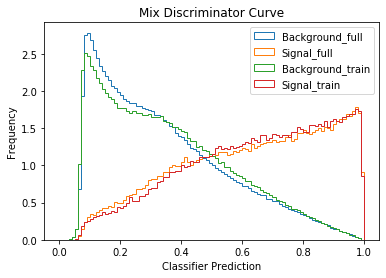

In [52]:
# Test and Training overlayed

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred, bins=bins, density = True, histtype = 'step', label = 'Background_full')
plt.hist(x= lst_of_values_signal_pred, bins=bins, density = True, histtype = 'step', label = 'Signal_full')
plt.title('Test - Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()


#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred_train, bins=bins, density = True, histtype = 'step', label = 'Background_train')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, density = True, histtype = 'step', label = 'Signal_train')
plt.title('Mix Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

num_bg_events_validation =  218652.0310266018
num_signal_events_validation =  4406.176757846028


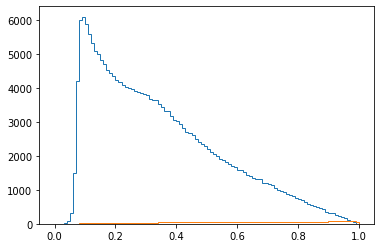

In [53]:
#Calculate number of events

n_bg, bins_bg, patches_bg = plt.hist(x= lst_of_values_bg_pred, bins=bins, weights = bg_weights*3e5,
         histtype = 'step', label = 'Background')
n_signal, bins_signal, patches_signal = plt.hist(x= lst_of_values_signal_pred, bins=bins, weights = df_weights[:Higg,3]*3e5,
         histtype = 'step', label = 'Signal')

# calculate the number of events
num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print('num_bg_events_validation = ', num_bg_events)
print('num_signal_events_validation = ', num_signal_events)

In [ ]:
df['True_Val']
x = df['Predicted']
print(x)

# Significance

$$ Z = \frac{s}{\sqrt(B+\sigma_s^{2})}  $$

s = number of signal

B = number of background

$\sigma_s$ = statistical uncertainty (~10% of B)

218652.0310266018
4406.176757846028


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


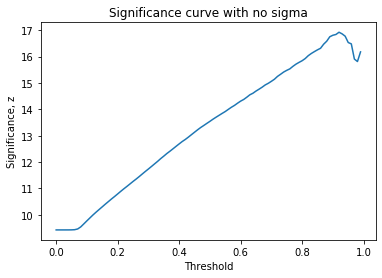

0.92
92
16.925528770386357

If cut at a threshold of 0.92 have
560.5703125 singal events
1096.921875 background events


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less


In [54]:
num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print(num_bg_events)
print(num_signal_events)

z = np.empty(len(bins_bg))
for i in range(len(bins_bg)):
    num_bg_events = np.sum(n_bg[i:])
    num_signal_events = np.sum(n_signal[i:])
    #print(num_signal_events)
    z_i = num_signal_events / np.sqrt(num_bg_events)
    z[i] = z_i
#print(z)


x = np.linspace(0,1,len(z))
plt.plot(bins_bg,z[:])
#plt.xlim([0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('Threshold')
plt.ylabel('Significance, z')
plt.title('Significance curve with no sigma')
plt.show()


mask = z < 1e10     #just so doesnt include infs
index_of_max = np.argmax(z[mask])
max_value = np.amax(z[mask])


#index_of_max = np.nanargmax(z[:])
#max_value = np.nanmax(z[:])     # 1 point before last, should probs generalise so that can deal w inf etc 
max_bin = bins_bg[index_of_max]
print(max_bin)
print(index_of_max)
print(max_value)

# significance = sigmna, 6.5 signma, 5 sigma

num_bg_threshold = np.sum(n_bg[index_of_max:])
num_signal_threshold = np.sum(n_signal[index_of_max:])

print()
print('If cut at a threshold of', index_of_max/100, 'have')
print(num_signal_threshold, 'singal events')
print(num_bg_threshold, 'background events')

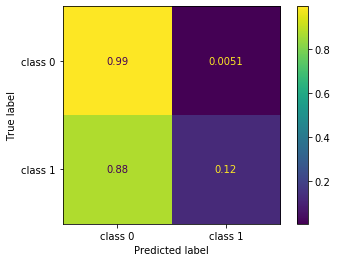

Total signal processes; 1.0
Total background processes; 1.0


In [55]:
# Confusion matricies with new threshold at max significance

# calculates prediction values
#y_pred = model.predict(X_valid) 

significance_threshold = max_bin
y_pred_threshold = np.where(y_pred >= significance_threshold, 1, 0)

# compute the confusion matrix
cm = confusion_matrix(y_valid, y_pred_threshold, normalize = 'true')    #,'true' ‘pred’, ‘all’},)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)   
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1']) # other env
disp.plot()
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

218652.0310266018
4406.176757846028


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


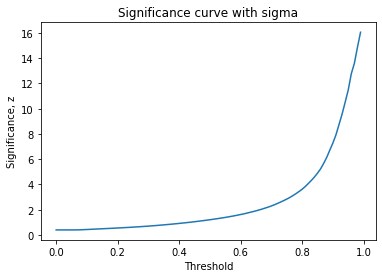

0.99
99
16.05846437989738

If cut at a threshold of 0.99 have
39.837890625 singal events
6.0625 background events


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less


In [56]:
# significance with statistical uncertainty term

num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print(num_bg_events)
print(num_signal_events)

z = np.empty(len(bins_bg))
for i in range(len(bins_bg)):
    num_bg_events = np.sum(n_bg[i:])
    num_signal_events = np.sum(n_signal[i:])
    #print(num_signal_events)
    z_i = num_signal_events / np.sqrt(num_bg_events + (0.05*num_bg_events)**2)
    
    z[i] = z_i
#print(z)


x = np.linspace(0,1,len(z))
plt.plot(bins_bg,z[:])
#plt.xlim([0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('Threshold')
plt.ylabel('Significance, z')
plt.title('Significance curve with sigma')
plt.show()


mask = z < 1e10     #just so doesnt include infs
index_of_max = np.argmax(z[mask])
max_value = np.amax(z[mask])


#index_of_max = np.nanargmax(z[:])
#max_value = np.nanmax(z[:])     # 1 point before last, should probs generalise so that can deal w inf etc 
max_bin = bins_bg[index_of_max]
print(max_bin)
print(index_of_max)
print(max_value)

num_bg_threshold = np.sum(n_bg[index_of_max:])
num_signal_threshold = np.sum(n_signal[index_of_max:])
print()
print('If cut at a threshold of', index_of_max/100, 'have')
print(num_signal_threshold, 'singal events')
print(num_bg_threshold, 'background events')
# significance = sigmna, 6.5 signma, 5 sigma

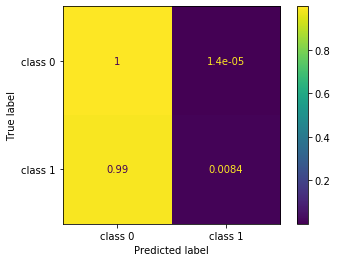

Total signal processes; 1.0
Total background processes; 1.0


In [57]:
# Confusion matricies with new threshold at max significance with statisitcal uncertainty

# calculates prediction values
#y_pred = model.predict(X_valid) 

significance_threshold = max_bin
y_pred_threshold = np.where(y_pred >= significance_threshold, 1, 0)

# compute the confusion matrix
cm = confusion_matrix(y_valid, y_pred_threshold, normalize = 'true')    #,'true' ‘pred’, ‘all’},)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)   
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1']) # other env
disp.plot()
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

218652.0310266018
4406.176757846028


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


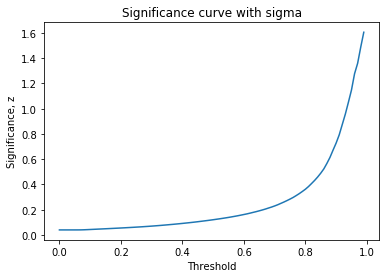

0.99
99
1.605846437989738

If cut at a threshold of 0.99 have
39.837890625 singal events
6.0625 background events


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less


In [58]:
# significance with statistical uncertainty term
# with only 10% 

num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print(num_bg_events)
print(num_signal_events)

z = np.empty(len(bins_bg))
for i in range(len(bins_bg)):
    num_bg_events = np.sum(n_bg[i:])
    num_signal_events = np.sum(n_signal[i:])
    #print(num_signal_events)
    z_i = (num_signal_events*0.1) / np.sqrt(num_bg_events + (0.05*num_bg_events)**2)
    
    z[i] = z_i
#print(z)


x = np.linspace(0,1,len(z))
plt.plot(bins_bg,z[:])
#plt.xlim([0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('Threshold')
plt.ylabel('Significance, z')
plt.title('Significance curve with sigma')
plt.show()


mask = z < 1e10     #just so doesnt include infs
index_of_max = np.argmax(z[mask])
max_value = np.amax(z[mask])


#index_of_max = np.nanargmax(z[:])
#max_value = np.nanmax(z[:])     # 1 point before last, should probs generalise so that can deal w inf etc 
max_bin = bins_bg[index_of_max]
print(max_bin)
print(index_of_max)
print(max_value)

num_bg_threshold = np.sum(n_bg[index_of_max:])
num_signal_threshold = np.sum(n_signal[index_of_max:])
print()
print('If cut at a threshold of', index_of_max/100, 'have')
print(num_signal_threshold, 'singal events')
print(num_bg_threshold, 'background events')
# significance = sigmna, 6.5 signma, 5 sigma